# IMPORTAÇÃO

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import ipywidgets as widgets
import plotly.express as px
import matplotlib.axes as ax
import scipy.stats as ss
import xgboost as xgb

from IPython.display import Image
from ipywidgets import fixed
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from boruta import BorutaPy 

# FUNÇÕES SUPORTE

In [2]:
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Cramer-V

In [3]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max( 0, chi2 - (k-1) * (r-1) / (n-1) )
    kcorr = k - (k-1)**2 / (n-1) 
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt( (chi2corr/n ) / min( kcorr-1, rcorr-1 ) )

### Base de Erro

In [4]:
def mean_absolute_percentual_error(y, yhat):
    return np.mean ( np.abs( (y - yhat) / y ))

def ml_error(name, y, yhat):
    
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentual_error(y, yhat)
    rmse = mean_squared_error(y, yhat)
    
    return pd.DataFrame( {'Model Name' : name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index = [0])

### Cross Validation
- Esse método é utilizado para segmentar os dados em kfolds ou agrupamentos, e utilizar uma parte deste para validação e o respto para treino, resultando no seguinte código:

In [5]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range( 1, kfold + 1 )):
        if verbose:
            print('\nkfold Number: {}'.format(k))
        
        # Start and End Validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k * 6 * 7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1) * 6 * 7)
        
        # Filtering Dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date ) & (x_training['date'] <= validation_end_date)]
        
        # training dataset
        xtraining = training.drop(['sales', 'date'], axis = 1)
        ytraining = training['sales']
        
        # validation dataset
        xvalidation = validation.drop(['sales', 'date'], axis = 1)
        yvalidation = validation['sales']
        
        # model
        m = model.fit(xtraining, ytraining)
        
        # predict
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store performance
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str) + '+/-' + np.round( np.std( mae_list ), 2 ).astype(str), 
                         'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype(str) + '+/-' + np.round( np.std( mape_list ), 2 ).astype(str), 
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round( np.std( rmse_list ), 2 ).astype(str)}, index = [0] )

# CARREGAMENTO DOS DADOS

In [6]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_stores_raw = pd.read_csv('data/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_stores_raw, how = 'left', on='Store')

# DESCRIÇÃO DOS DADOS

### Rename Columns: 

Nessa iremos alterar o nome das colunas de "camelcase" para "sneakcase"

In [7]:
df1 = df_raw.copy()

In [8]:
past_columns = [ 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
                 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                 'Promo2SinceYear', 'PromoInterval']

sneakcase = lambda x: inflection.underscore(x)
list_columns = list(map(sneakcase, past_columns))

df1.columns = list_columns
df1

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.000,11.000,2007.000,1,13.000,2010.000,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.000,12.000,2006.000,1,14.000,2011.000,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.000,9.000,2009.000,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.000,4.000,2015.000,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.000,6.000,2014.000,1,31.000,2013.000,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.000,4.000,2006.000,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.000,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.000,NaN,NaN,0,NaN,NaN,NaN


### Dimensão dos Dados
Nesse setor iremos verificar a quantidade de linhas e colunas do nosso dataframe para verificar o tamanho de dados que temos.

In [9]:
print('Number of rowls: {} '.format(df1.shape[0]))
print('Number of columns: {} '.format(df1.shape[1]))

Number of rowls: 1017209 
Number of columns: 18 


### Tipos de Dados
Nesse setor iremos analisar os tipos de dados existentes

In [10]:
df1.date = pd.to_datetime(df1.date)
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### Checagem de Valores NA
Temos três métodos para alterar a presença de valores inexistentes, sendo estes:
- Eliminação dos valores NaN
- Usando algoritmos de "Machine Learning" para alterar os valores NaN
- Entender os motivos destes estarem presente nos dados e então realizar a alteração. <br>
Neste momento iremos utilizar o ultimo método.

In [11]:
# competition_distance
# Substituir os valores NaN para os valores máximos
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month 
# Substituir os valores NaN para os valores de meses
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year   
# Substituir os valores NaN para os valores do ano
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

# promo2_since_week   
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# promo_interval  
month_map = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
            7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

# Substituir os valores NaN para 0
df1['promo_interval'].fillna(0, inplace = True)

df1['month_promo'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_promo']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_promo'] in x['promo_interval'].split(',') else 0, axis = 1)

## Estatísticas Descritivas

Neste setor iremos realizar algumas estatísticas descritivas para entender melhor nossos dados, iremos inicialmente realizar algumas métricas simples para que no próximo ciclo seja implementada com mais robustez

In [12]:
# Select dtypes 
df_num = df1.select_dtypes(include = ['int64', 'float64'])
df_cat = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

# min, max, range, mean, median, std, skew
df_min = pd.DataFrame(df_num.min())
df_max = pd.DataFrame(df_num.max())
df_range = pd.DataFrame(df_num.max() - df_num.min())
df_mean = pd.DataFrame(df_num.mean())
df_median = pd.DataFrame(df_num.median())
df_std = pd.DataFrame(df_num.std())
df_skew = pd.DataFrame(df_num.skew())
df_kurtosis = pd.DataFrame(df_num.kurtosis())

df_metrics = pd.concat([df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis], axis = 1)
df_metrics.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
df_metrics

,min,max,range,mean,median,std,skew,kurtosis
store,1.000,1115.000,1114.000,558.430,558.000,321.909,-0.001,-1.201
day_of_week,1.000,7.000,6.000,3.998,4.000,1.997,0.002,-1.247
sales,0.000,41551.000,41551.000,5773.819,5744.000,3849.926,0.641,1.778
customers,0.000,7388.000,7388.000,633.146,609.000,464.412,1.599,7.092
open,0.000,1.000,1.000,0.830,1.000,0.376,-1.758,1.091
promo,0.000,1.000,1.000,0.382,0.000,0.486,0.488,-1.762
school_holiday,0.000,1.000,1.000,0.179,0.000,0.383,1.678,0.815
competition_distance,20.000,200000.000,199980.000,5935.443,2330.000,12547.653,10.242,147.790
competition_open_since_month,1.000,12.000,11.000,6.787,7.000,3.311,-0.042,-1.233
competition_open_since_year,1900.000,2015.000,115.000,2010.325,2012.000,5.516,-7.236,124.071


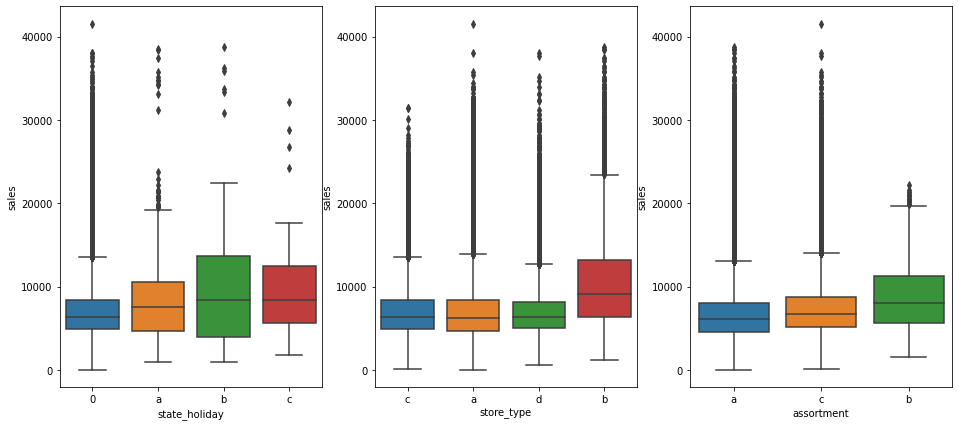

In [13]:
# Filtrando os valores
df_aux = df1[(df1['sales'] > 0) & (df1['state_holiday'] != 0)]

# Criando os subplots
fig, axis = plt.subplots(1, 3,figsize = (16,7));
sns.boxplot(data = df_aux, x = 'state_holiday', y = 'sales', ax = axis[0]);
sns.boxplot(data = df_aux, x = 'store_type', y = 'sales', ax = axis[1]);
sns.boxplot(data = df_aux, x = 'assortment', y = 'sales', ax = axis[2]);

# FEATURE ENGENEERING

## Mapa Mental

Iremos realizar um mapa mental para apresentar todas as variáveis contidas em nosso problema, dando este suporte para a realização de hipóteses. <br>
No mundo corporativo, esse mapa mental é produzido a partir da reunião de "insights" com outras equipes da empresa.

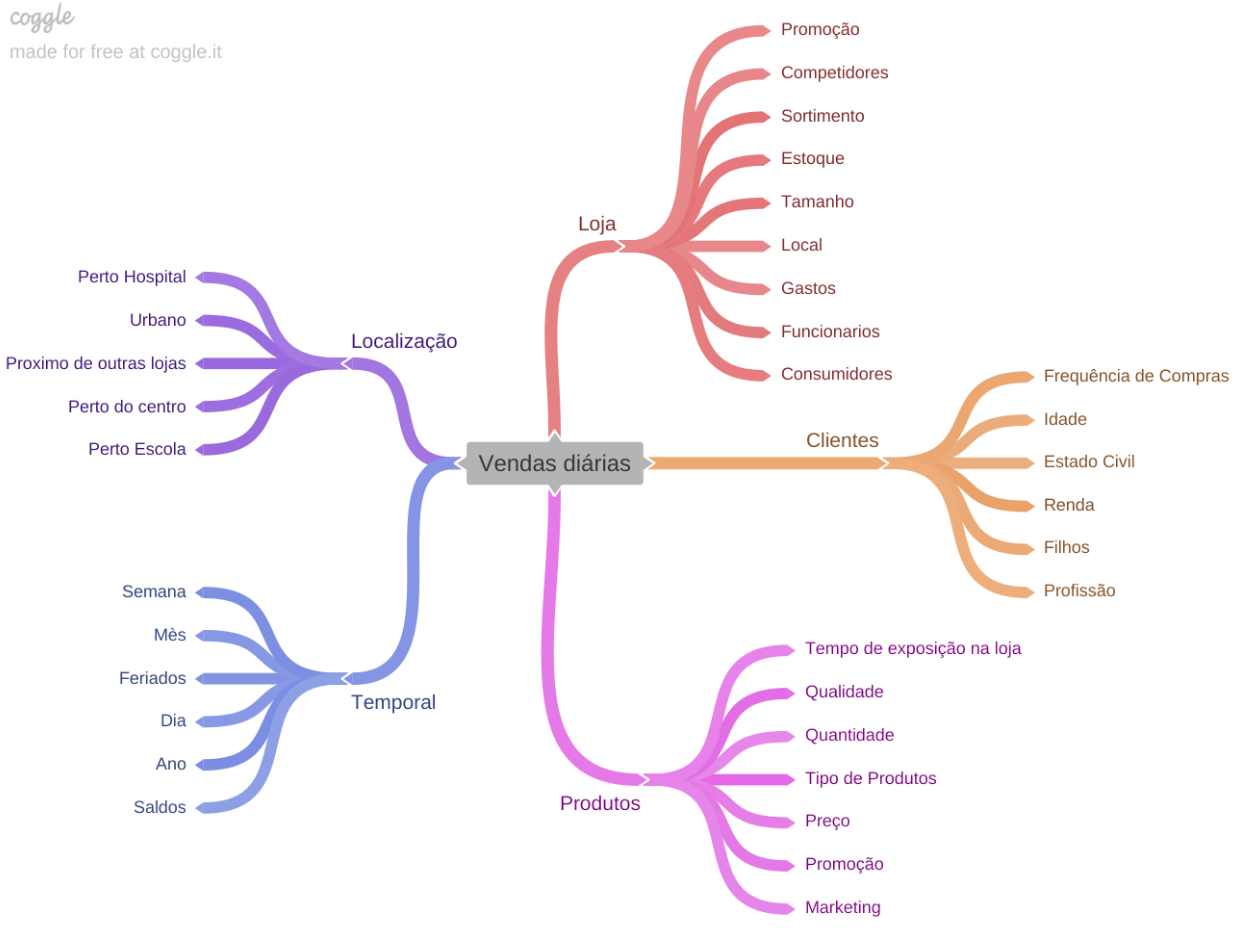

In [14]:
Image('imagens/mindmap.png')

## Hipóteses
A partir do mapa mental, iremos desenvolver as hipóteses das variáveis que levantamos<br>
Lembrando que no dia a dia da empresa, tanto as hipóteses como o mapa mental é construido a partir da reunião com outras áreas, fornecendo estas "insights" para a construção destes.

### Hipótese da Loja

- Quanto maior o estoque, maior será a venda da loja?
- Quanto maior o número de funcionários, maior é o faturamento da loja?
- Lojas que se localizam no centro vendem mais do que as que se localizam fora deste?
- Loja com maior sortimento (diferentes tipos) tem mais vendas?
- Loja com concorrentes próximos tendem a vender menos?
- Lojas com concorrentes a mais tempo vendem mais?
- Loja com promoções vender mais?
- Loja com mais promoções consecutivas vender mais?

### Hipóteses do Produto
- Produtos com maior tempo de exposição da loja vendem mais?
- Produtos com uma qualidade maior vendem mais?
- Produtos que tem uma maior quantidade em vendem mais?
- Produtos com menor preço vendem mais?
- Produtos em que tem mais promoções vendem mais?
- Produtos em que se investem mais em marketing vendem mais?

### Hipóteses Temporal
- Lojas deveriam vender mais durante a semana do que nos fins de semana?
- Lojas vendem mais nos feriados?
- Lojas vendem mais com o passar dos anos?
- Lojas vendem mais durante o fim do ano?
- Lojas que tem mais promoções vendem mais?

### Hipóteses Selecionadas
Com as hipóteses levantadas, iremos em seguida realizar uma seleção de quais hipóteses podemos validar neste momento tendo como base os dados que possuímos resultando então nas seguintes hipóteses:

### Hipótese da Loja
1. Loja com maior sortimento (diferentes tipos) tem mais vendas?
2. Loja com concorrentes próximos tendem a vender menos?
3. Loja com promoções vender mais?
4. Lojas com promoções ativas a mais tempo tendem a vender mais?
5. Loja com promoções vendem mais?
6. Lojas com promoções consecutivas vendem mais?

### Hipóteses Temporal
6. Lojas deveriam vender mais durante a semana do que nos fins de semana?
7. Lojas vendem mais nos feriados?
8. Lojas vendem mais com o passar dos anos?
9. Lojas vendem mais durante o fim do ano?
10. Lojas vendem mais durante o natal?
11. Lojas vendem mais depois do dia 10 de cada mês?
12. Lojas vendem mais durante o segundo semestre do ano?

## Feature Engeneering

Neste setor iremos criar algumas variáveis que irão nos auxiliar para a análise dos dados. 

In [15]:
df2 = df1.copy()

In [16]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_promo                             object
is_promo                                 int64
dtype: object

In [17]:
# Criando a variável year
df2['year'] = df2['date'].dt.year

# Criando a variável month
df2['month'] = df2['date'].dt.month

# Criando a variável day
df2['day'] = df2['date'].dt.day

# Criando a variável de semanas do ano
df2['week_of_year'] = df2['date'].dt.week

# Criando a variável semana e ano
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Criando a variável competition since
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype('int64')
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype('int64')
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)

# Criando a variável promoção / mês 
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# Criando a vari[avel promo since
df2['promo2_since_year'] = df2['promo2_since_year'].astype('int64')
df2['promo2_since_week'] = df2['promo2_since_week'].astype('int64')
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))

# Criando a variável de semanas 
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7).apply(lambda x: x.days).astype(int)

# Alterando a variável Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# Alterando a variável holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x:  'public_holiday' if x =='a' else 'easter' if x =='b' else 'christmas' )

/tmp/ipykernel_20866/2313606404.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.week


In [18]:
df2

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_promo,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,christmas,1,c,basic,1270.000,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,christmas,1,a,basic,570.000,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,christmas,1,a,basic,14130.000,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,christmas,1,c,extended,620.000,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,christmas,1,a,basic,29910.000,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,public_holiday,1,a,basic,1900.000,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",Jan,1,2013,1,1,1,2013-00,2014-06-01,-18,2013-07-29,-30
1017205,1112,2,2013-01-01,0,0,0,0,public_holiday,1,c,extended,1880.000,4,2006,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2006-04-01,82,2012-12-31,0
1017206,1113,2,2013-01-01,0,0,0,0,public_holiday,1,a,extended,9260.000,1,2013,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0
1017207,1114,2,2013-01-01,0,0,0,0,public_holiday,1,a,extended,870.000,1,2013,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


# FILTRAGEM DE VARIÁVEIS

In [19]:
df3 = df2.copy()

## Seleção das linhas

In [20]:
df3 = df3[(df3['sales'] > 0) & (df3['open'] == 1)]

## Seleção das colunas

In [21]:
df3 = df3.drop(['open', 'promo_interval'], axis = 1)

# ANÁLISE EXPLORATÓRIA DOS DADOS

In [22]:
df4 = df3.copy()

## Análise Univariada

### Variável Resposta

<Figure size 1008x504 with 0 Axes>

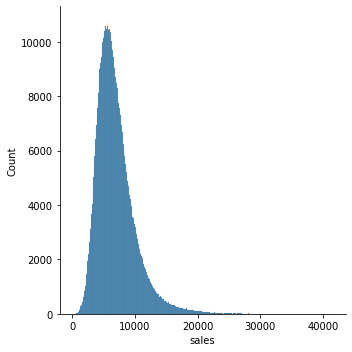

In [23]:
plt.figure(figsize = (14,7))
sns.displot(df4['sales'])

### Variáveis Numéricas

In [24]:
df4_num = df4.select_dtypes(include = ['int64', 'float64'])

In [25]:
#Este é um  gráfico dinâmico da qual funcioa apenas quando estiver feito o download

attr_selector = widgets.Dropdown(
    options = df4_num.columns ,
    value= df4_num.columns[0],
    description='Select atributes:',
    disabled=False)

def graphic (df4_num, attr_selector):
    fig = px.histogram(df4_num, x = attr_selector)
    fig.show()
    
widgets.interactive(graphic, df4_num = fixed(df4_num), attr_selector = attr_selector)

interactive(children=(Dropdown(description='Select atributes:', options=('store', 'day_of_week', 'sales', 'cus…

### Variáveis Categóricas

In [26]:
df4_cat = df4.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [27]:
#Este é um  gráfico dinâmico da qual funcioa apenas quando estiver feito o download

attr_selector = widgets.Dropdown(
    options = df4_cat.columns ,
    value= df4_cat.columns[0],
    description='Select atributes:',
    disabled=False)

def graphic (df4_cat, attr_selector):
    fig = px.histogram(df4_cat, x = attr_selector)
    fig.show()
    
widgets.interactive(graphic, df4_cat = fixed(df4_cat), attr_selector = attr_selector)

interactive(children=(Dropdown(description='Select atributes:', options=('state_holiday', 'store_type', 'assor…

## Análise Bivariada

### H1: Loja com maior sortimento (diferentes tipos) tem mais vendas?
- **FALSO:** Supondo que a versão extra é a que contém mais tipos de sortimentos, esta afirmação é falsa, pois o sortimento extra representa uma soma de vendas menor que as com menores variedades. 
- Outro aspecto que vemos é que a versão "basic" e "extended" possuem um valor aproximado de soma de vendas, mas apesar disso não podemos desconsidear a versão "extra" pois contém valores relevantes.

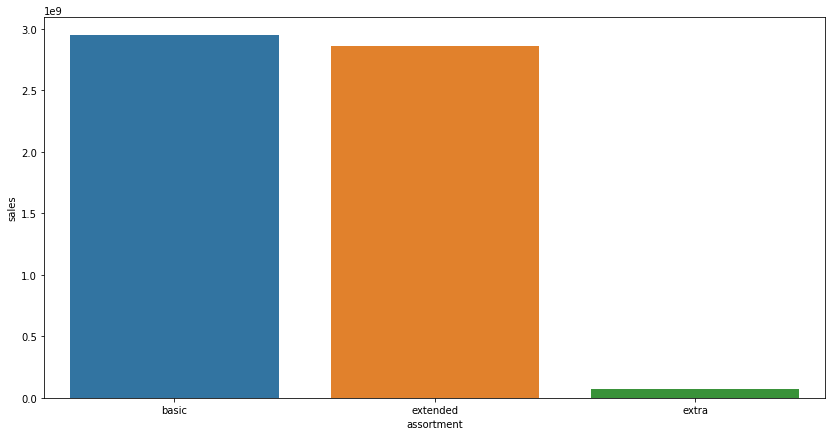

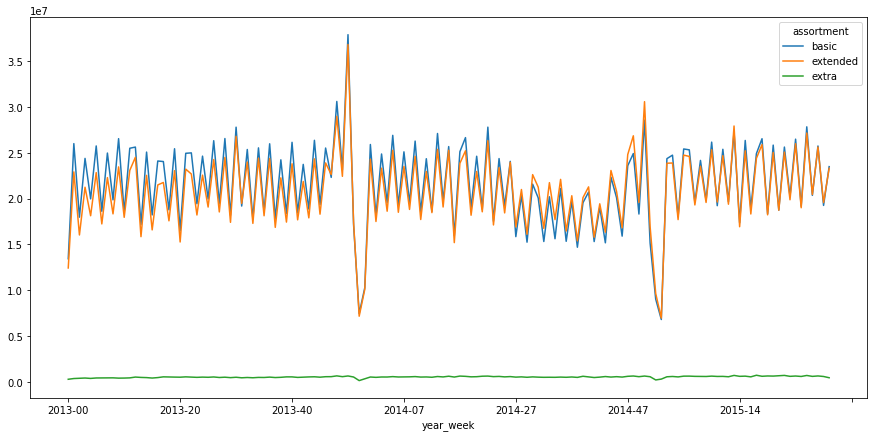

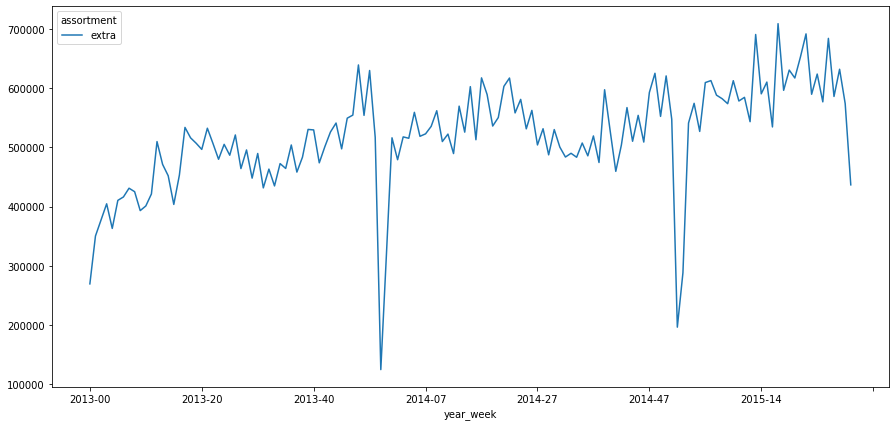

In [28]:
# Plotagem do gráfico de barras assortment x sales
plt.figure(figsize = (14,7))
df_aux_1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(data = df_aux_1, x = 'assortment', y = 'sales');

# Plotagem do gráfico de linhas de vendas de acordo com a linha do tempo
df_aux_2 = df4[['assortment', 'sales', 'year_week']].groupby(['year_week', 'assortment']).sum().reset_index()
df_aux_2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot(figsize = (15,7));

# Plotagem dos gráficos de vendas do tamanho extra em relação com a linha do tempo
df_aux_3 = df_aux_2[df_aux_2['assortment'] == 'extra']
df_aux_3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot(figsize = (15,7));

### H2: Lojas com competidores mais próximos, deveriam vender menos?
- **FALSA:** Lojas com competidores próximos vendem mais do que com competidores distantes.
- Isso pode ser explicado pelo fato de todas as lojas se situarem em locais com mais circulação de pessoas.

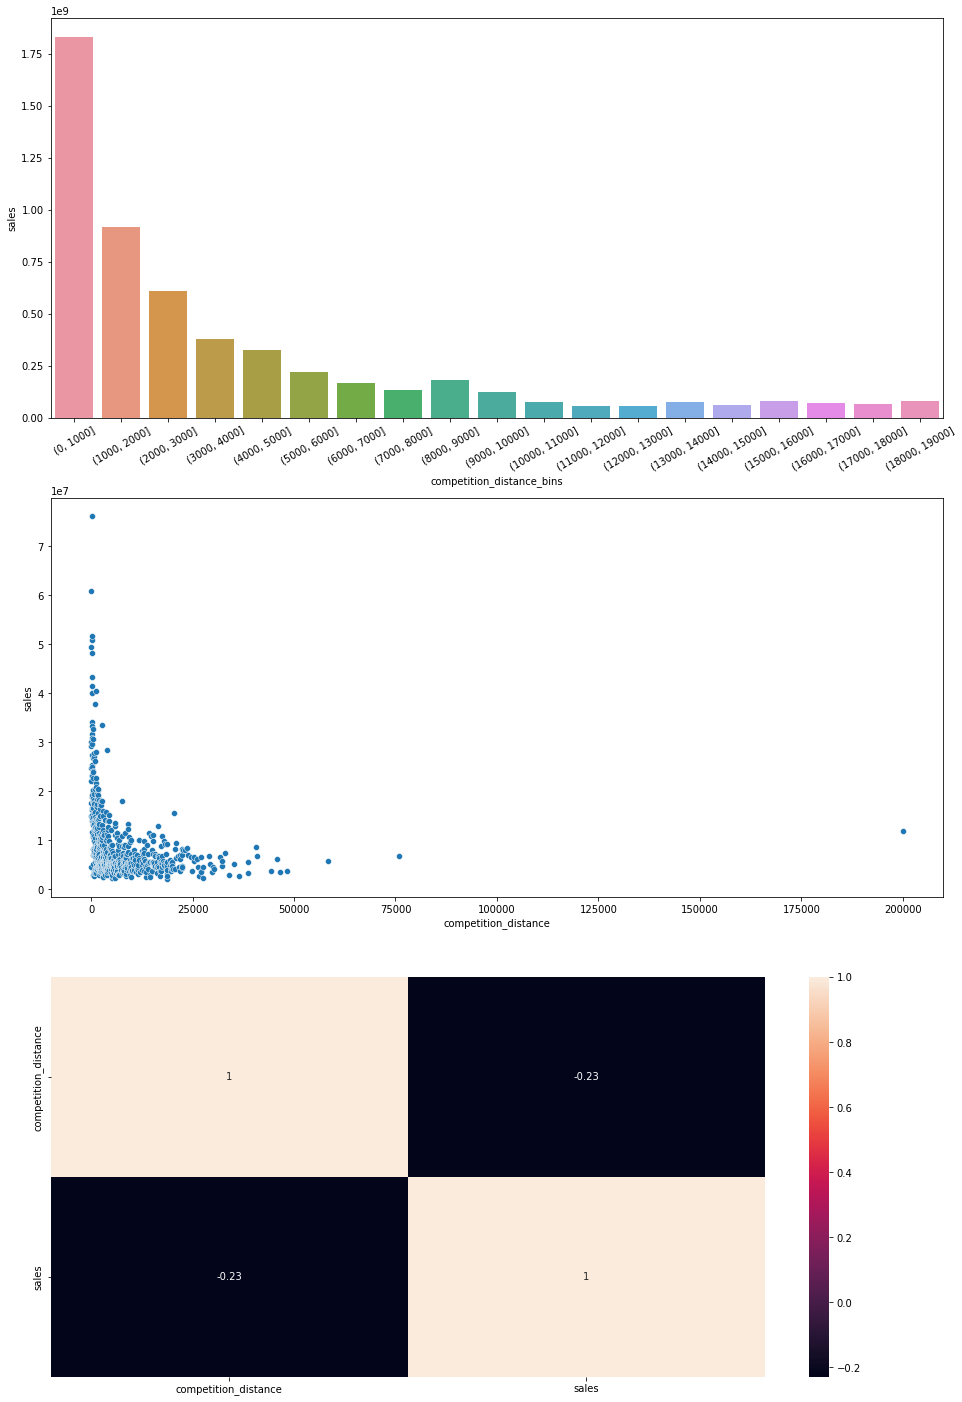

In [29]:
# Definindo o tamanho da figura
plt.figure(figsize = (16,25))

# Agrupando os dados de acordo com as variáveis que desejamos
aux_1 = df4[['sales', 'competition_distance']].groupby('competition_distance').sum().reset_index()

# Segmentação dos dados da distância de 1000 em 1000
bins = list(np.arange(0,20000, 1000))
aux_1['competition_distance_bins'] = pd.cut(x = aux_1['competition_distance'], bins = bins)

# Criando os dados agrupados 2 contendo a distância 
aux_2 = aux_1[['competition_distance_bins', 'sales']].groupby('competition_distance_bins').sum().reset_index()

# Plotagem do gráfico de barras
plt.subplot(3,1,1);
sns.barplot(data = aux_2, x = 'competition_distance_bins', y = 'sales');
plt.xticks(rotation = 30)

# Plotagem scatterplot 
plt.subplot(3,1,2);
sns.scatterplot(data = aux_1, x = 'competition_distance', y = 'sales');

# Plotagem dos dados de correlação entre vendas e distância
plt.subplot(3,1,3);
sns.heatmap(aux_1.corr(), annot = True);

### H3: Lojas com concorrentes a mais tempo vendem mais?
- **FALSO:** Como podemos ver há um crescimento das vendas quando ocorre uma abertura de um concorrente próximo e com o tempo as vendas tendem a cair com a prensença de competidores.
- Vemos também que esta contém uma correlação relevante (0,11), algo que será considerado ao modelarmos na etapa de ML.

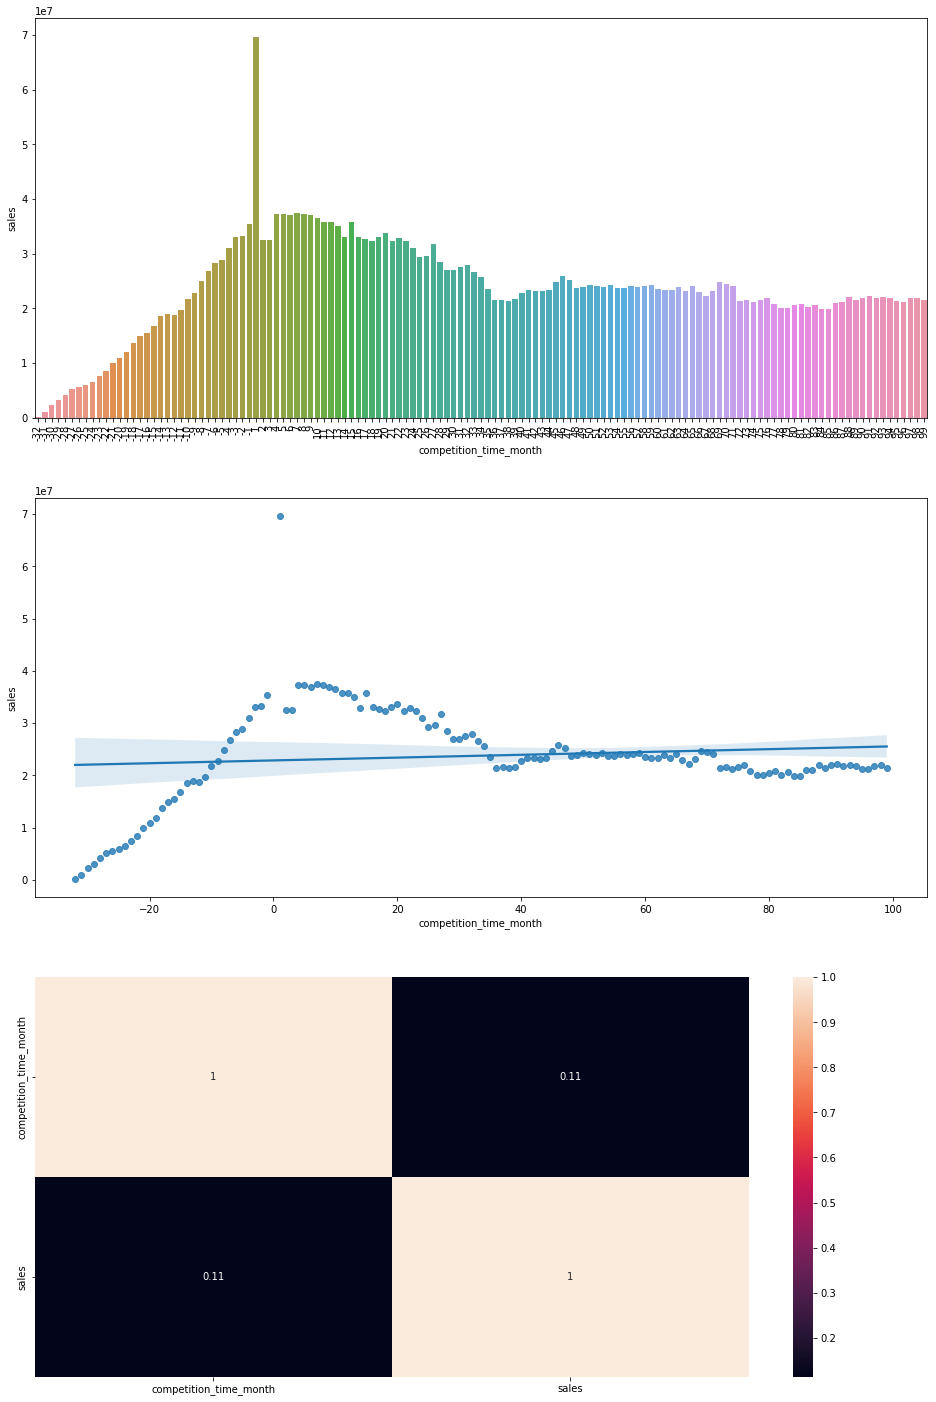

In [30]:
# Criando a figura
plt.figure(figsize = (16,25))

# Criando os dados que iremos utilizar
aux2 = df4[['sales', 'competition_time_month']].groupby('competition_time_month').sum().reset_index()
df_filter = aux2[(aux2['competition_time_month'] < 100) & (aux2['competition_time_month'] != 0)]

# Criando o gráfico de barras
plt.subplot(3,1,1);
sns.barplot(data = df_filter, x = 'competition_time_month', y = 'sales');
plt.xticks(rotation = 90);

# Criando o gráfico regplot para medir a força da correlação
plt.subplot(3,1,2);
sns.regplot(data = df_filter, x = 'competition_time_month', y = 'sales');

# Criação do gráfico de correlação
plt.subplot(3,1,3);
sns.heatmap(df_filter.corr(), annot= True);

### H4: Lojas com promoções ativas a mais tempo tendem a vender mais?
- **FALSA:** Quanto mais tempo a promoção ativa menor é o valor de venda.
- Um dos aspectos a serem observados é que antes da promoção ocorre um aumento de vendas, um dos fatos que pode contribuir para esse aumento é um investimento no marketing, mas isso é apenas uma suposição sem dados.
- Outro aspecto que vemos é uma fraca correlação entre essas duas variáveis, sendo esse um dos fatores que teremos que verificar na hora de seleção das variáveis para inserir em nosso modelo de ML.

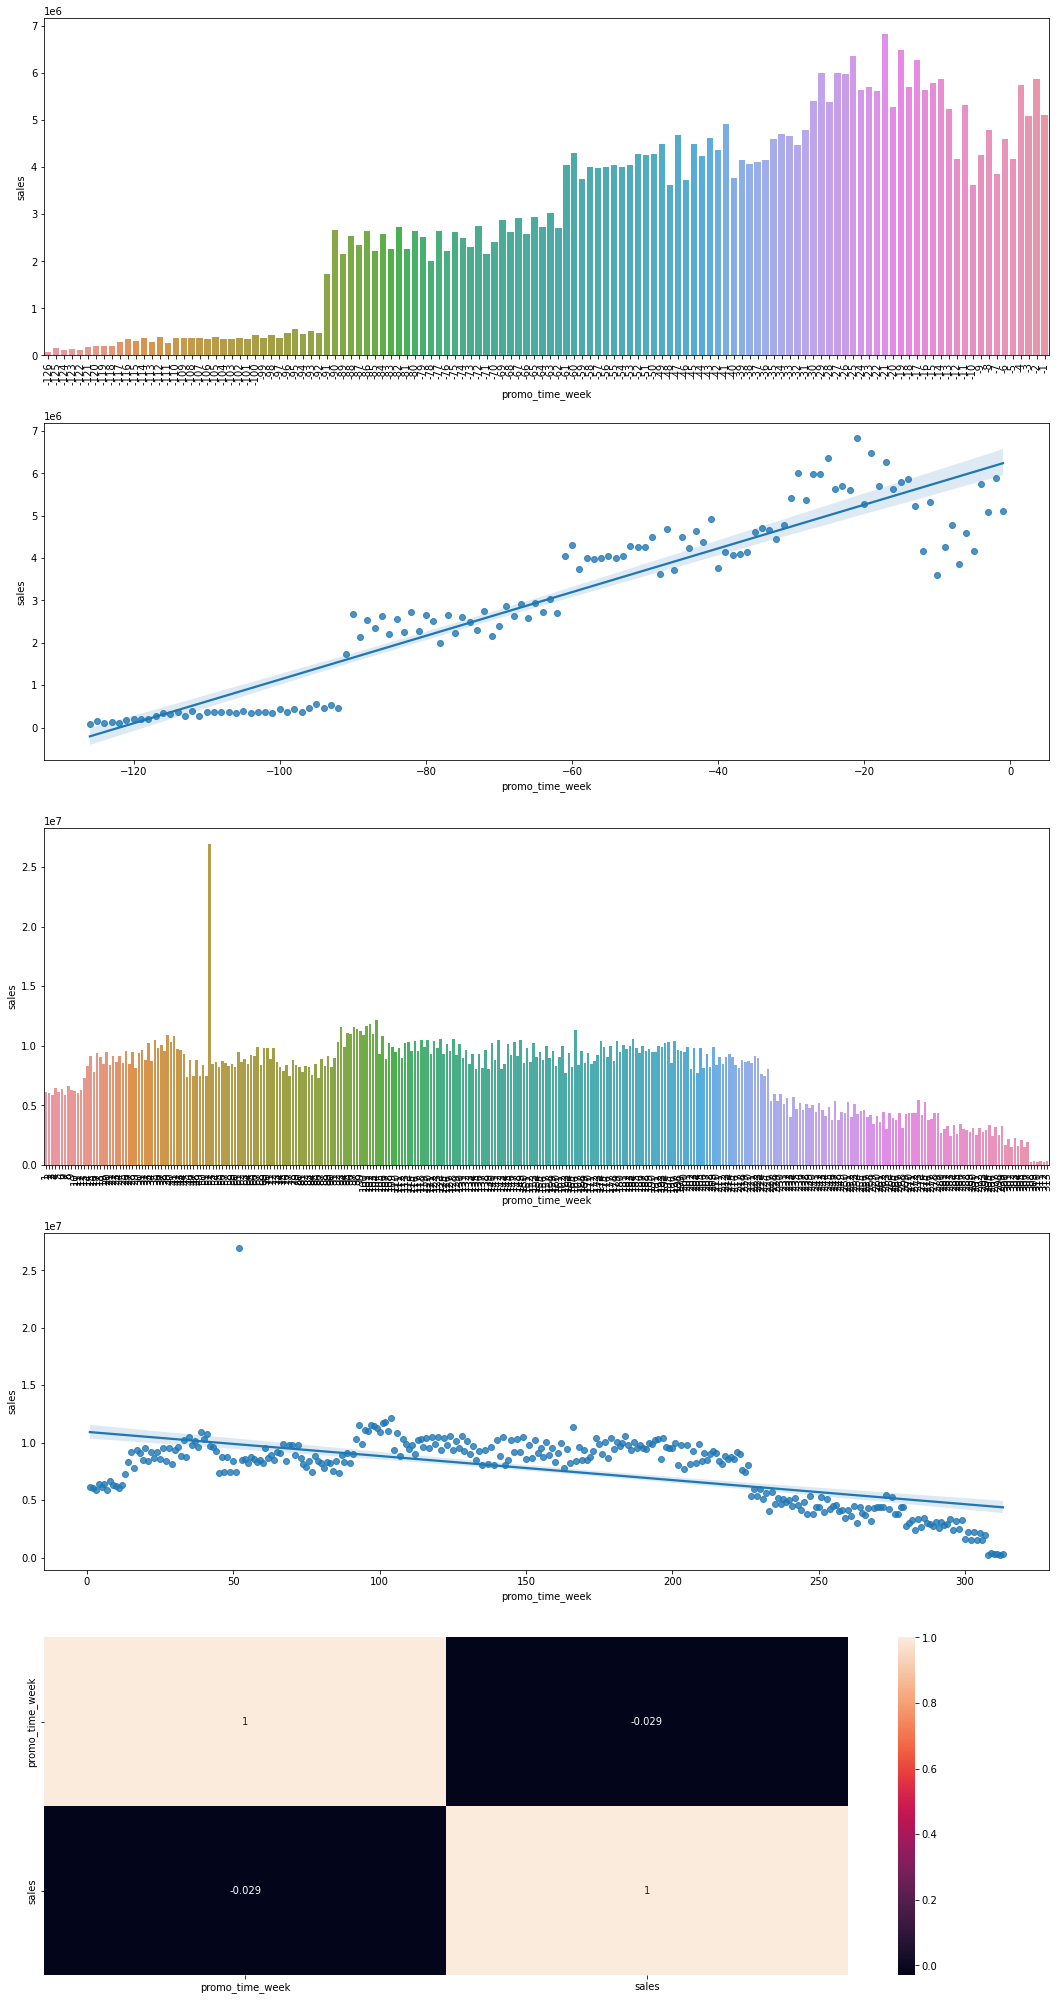

In [31]:
plt.figure(figsize = (18,36));
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# Plotagem do gráfico de barras com valores menores que 0
# Valores menores que 0 significa o período antes da promoção
plt.subplot(5,1,1);
aux2 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(data = aux2, x = 'promo_time_week', y = 'sales');
plt.xticks(rotation = 90);

# Plotagem do gráfico para confirmar a força da correlação
plt.subplot(5,1,2);
sns.regplot(data = aux2, x = 'promo_time_week', y = 'sales');

# Plotagem do gráfico de barras com valores maiores que 0
# Valores maiores que 0 significa o período depois da promoção
plt.subplot(5,1,3);
aux3 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(data = aux3, x = 'promo_time_week', y = 'sales');
plt.xticks(rotation = 90);

# Plotagem do gráfico para confirmar a força da correlação
plt.subplot(5,1,4);
sns.regplot(data = aux3, x = 'promo_time_week', y = 'sales');

# Plotagem dos dados correlacionados
plt.subplot(5,1,5);
sns.heatmap(aux1.corr(), annot=True);

### H5: Loja que tem promoções vendem mais?
- **FALSO:** Podemos ver que as lojas que não contém promoções tem uma quantidade média de vendas ligeiramente maior que as lojas com promoções, assim como veremos que a distribuição média de vendas de produtos entre lojas que realizaram a promoção não é distante das lojas que não realizaram esta.

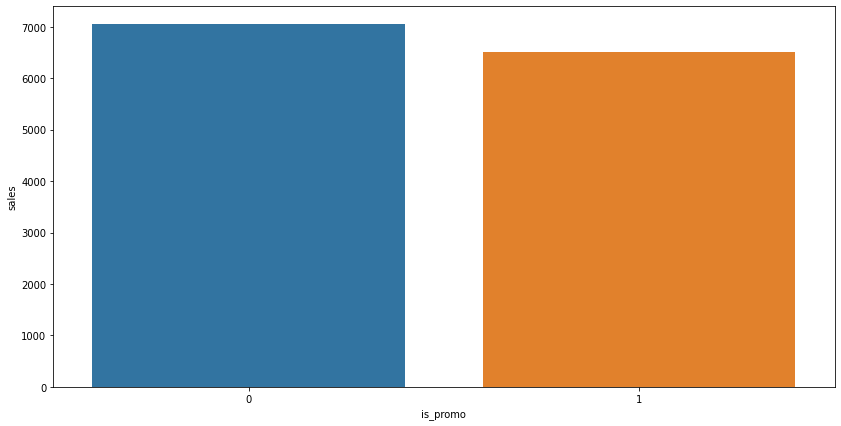

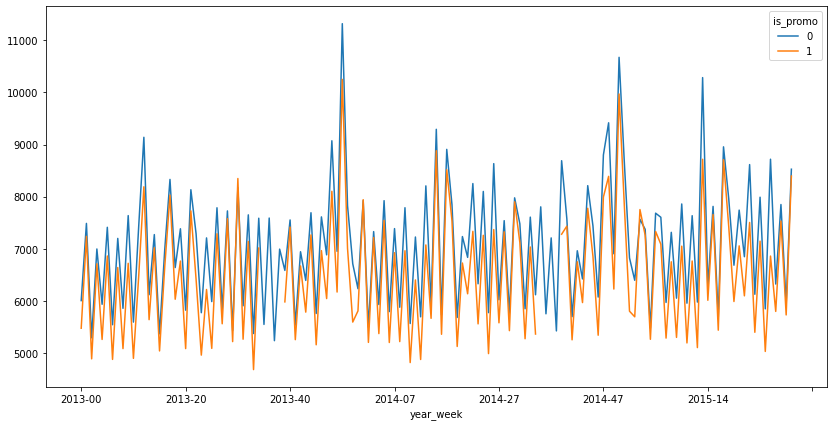

In [32]:
plt.figure(figsize = (14,7))
df_aux = df4[['is_promo', 'sales']].groupby('is_promo').mean().reset_index()
sns.barplot(data= df_aux, x = 'is_promo', y = 'sales');

df_aux_2 = df4[['is_promo', 'year_week', 'sales']].groupby(['year_week', 'is_promo']).mean().reset_index()
df_aux_3 = df_aux_2.pivot(index = 'year_week', columns = 'is_promo', values = 'sales').plot(figsize = (14,7))

### H6: Loja com promoções consecutivas vender mais?
- **FALSO:** Vemos que as lojas que participam de uma promoção consecutiva contém uma soma de faturamento não muito discrepante das lojas que não participaram das promoções.

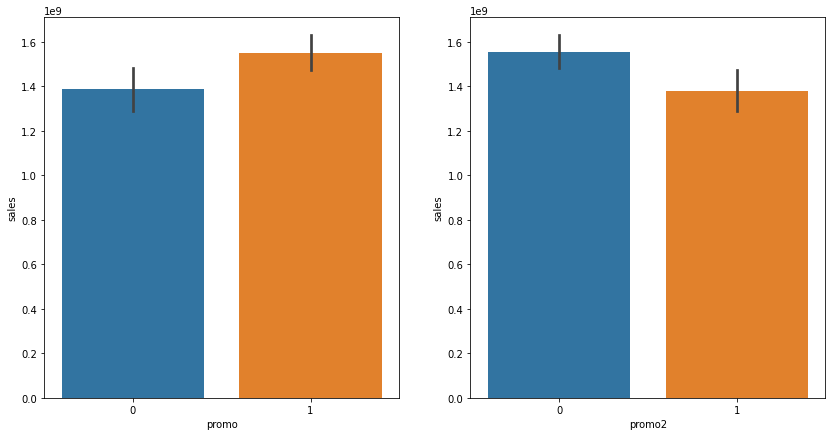

In [33]:
plt.figure(figsize = (14,7))
aux1 = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(data = aux1, x = 'promo', y = 'sales');

plt.subplot(1,2,2)
sns.barplot(data = aux1, x = 'promo2', y = 'sales');

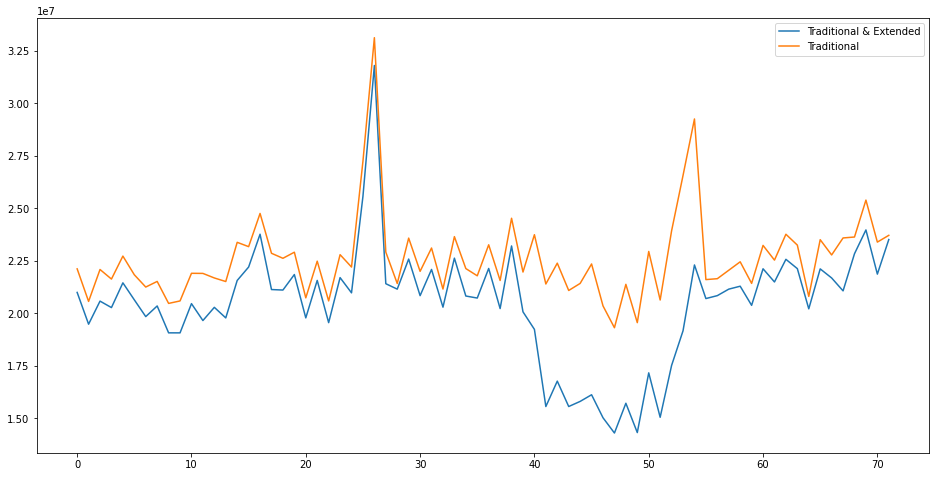

In [34]:
# Dados que participaram da promoção tradicional e extendida
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux2.plot(figsize = (16,8));

# Dados que participaram da promoção tradicional
aux3 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux3.plot(ax = ax);

ax.legend(labels = ['Traditional & Extended', 'Traditional']);

### H7: Lojas deveriam vender mais no fim de semana do que  durante a semana?
- **FALSO:** O que ocorre é uma diminuição na soma de vendas com o passar da semana, sendo que no domingo (dia 7) ocorre uma diminuição brusca das vendas.

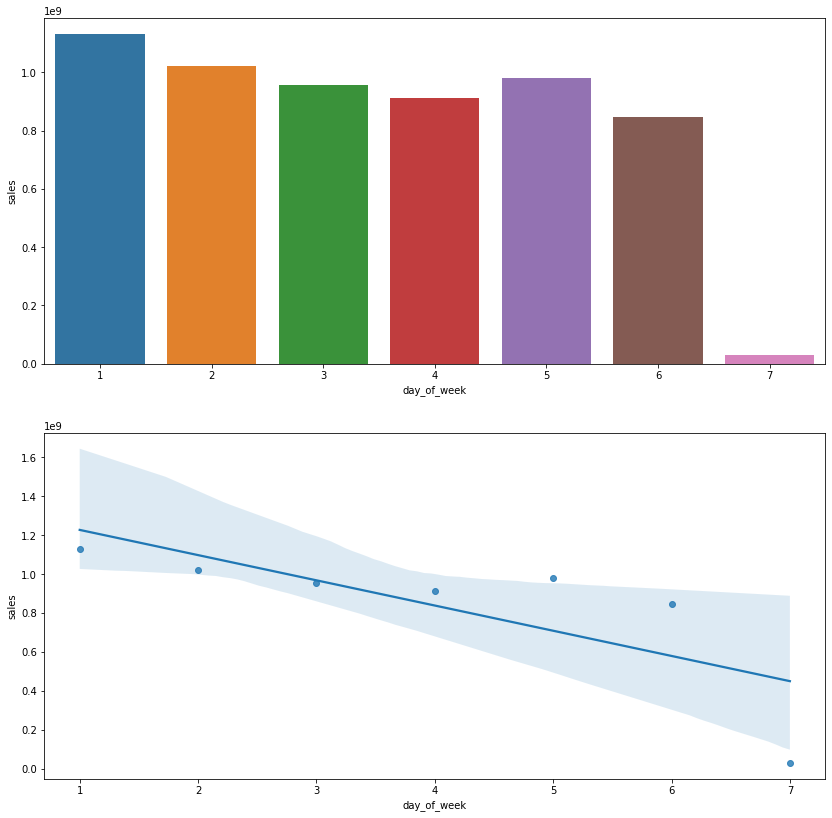

In [35]:
plt.figure(figsize = (14,14))

# Agrupando os dados
df_aux = df4.copy()
df_group_aux = df_aux[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

# Plotagem do gráfico
plt.subplot(2,1,1)
sns.barplot(data = df_group_aux, x = 'day_of_week', y = 'sales', order = df_group_aux['day_of_week']);

plt.subplot(2,1,2)
sns.regplot(data = df_group_aux, x = 'day_of_week', y = 'sales');

### H8: Lojas vendem mais nos feriados?
- **FALSO:** Não vemos nenhuma diferença significativa na média de vendas havendo um feriado ou não.

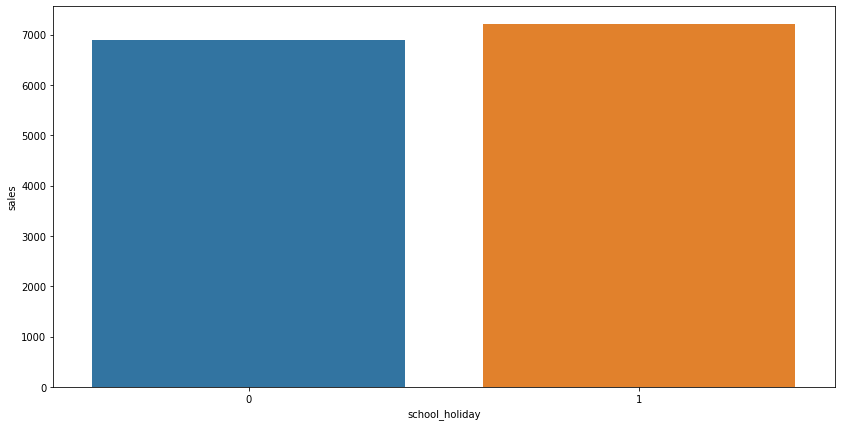

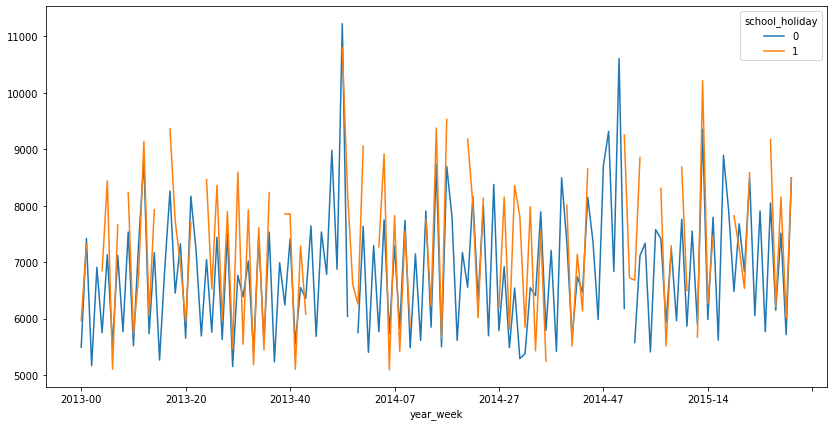

In [36]:
# Seleção e agrupamento dos dados
df_group_aux = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

# Plotagem dos gráficos
plt.figure(figsize = (14,7));
sns.barplot(data = df_group_aux, x = 'school_holiday', y = 'sales');

# Seleção e agrupamento dos dados e plotagem dos gráficos
df_group_aux_2 = df4[['school_holiday', 'year_week', 'sales']].groupby(['year_week', 'school_holiday']).mean().reset_index()
df_group_aux_2.pivot(index = 'year_week', columns = 'school_holiday', values = 'sales').plot(figsize = (14,7));

### H9: Lojas vendem mais com o passar dos anos?
- **FALSO:** Houve uma diminuição da soma de vendas durante os anos.

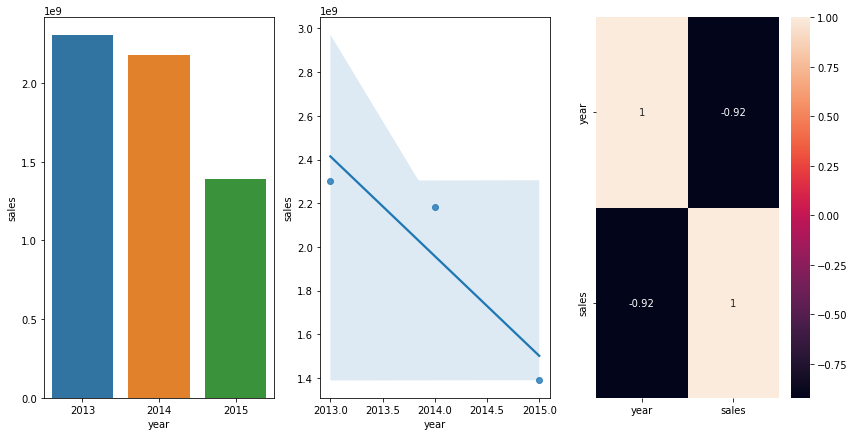

In [37]:
df_group_aux = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.figure(figsize = (14,7));

plt.subplot(1,3,1)
sns.barplot(data = df_group_aux, x = 'year', y = 'sales');

plt.subplot(1,3,2)
sns.regplot(data = df_group_aux, x = 'year', y = 'sales');

plt.subplot(1,3,3)
sns.heatmap(data = df_group_aux.corr(), annot= True);

### H10: Lojas abertas durante o natal, deveriam vender mais?
- **FALSO:** Podemos ver que a média de vendas durante o natal é menor que outros feriados.

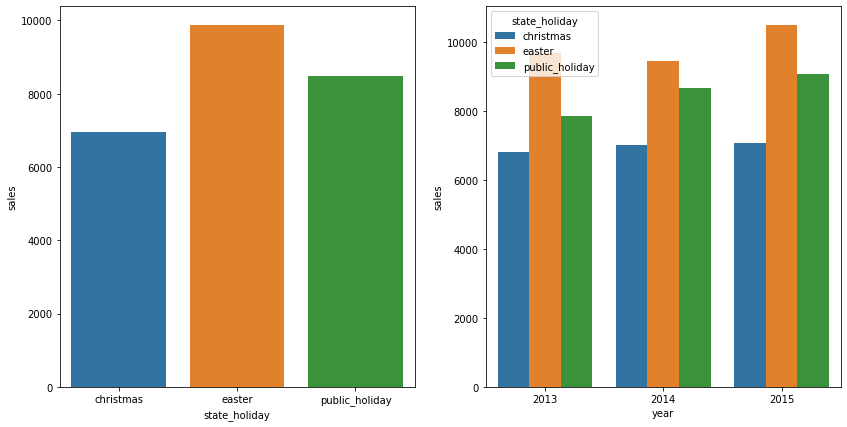

In [38]:
plt.figure(figsize = (14,7));

aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()

plt.subplot(1,2,1);
sns.barplot(data = aux1, x = 'state_holiday', y = 'sales');

plt.subplot(1,2,2);
aux2 = df4[['year', 'sales', 'state_holiday']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(data = aux2, x = 'year', y = 'sales', hue = 'state_holiday');

### H11: Lojas vendem mais antes do dia 10 de cada mês?
- **FALSO:** Não vemos nenhuma indicação de que ocorre um aumento da soma de vendas antes do dia 10, o que vemos é um aumento de vendas depois do dia 10.

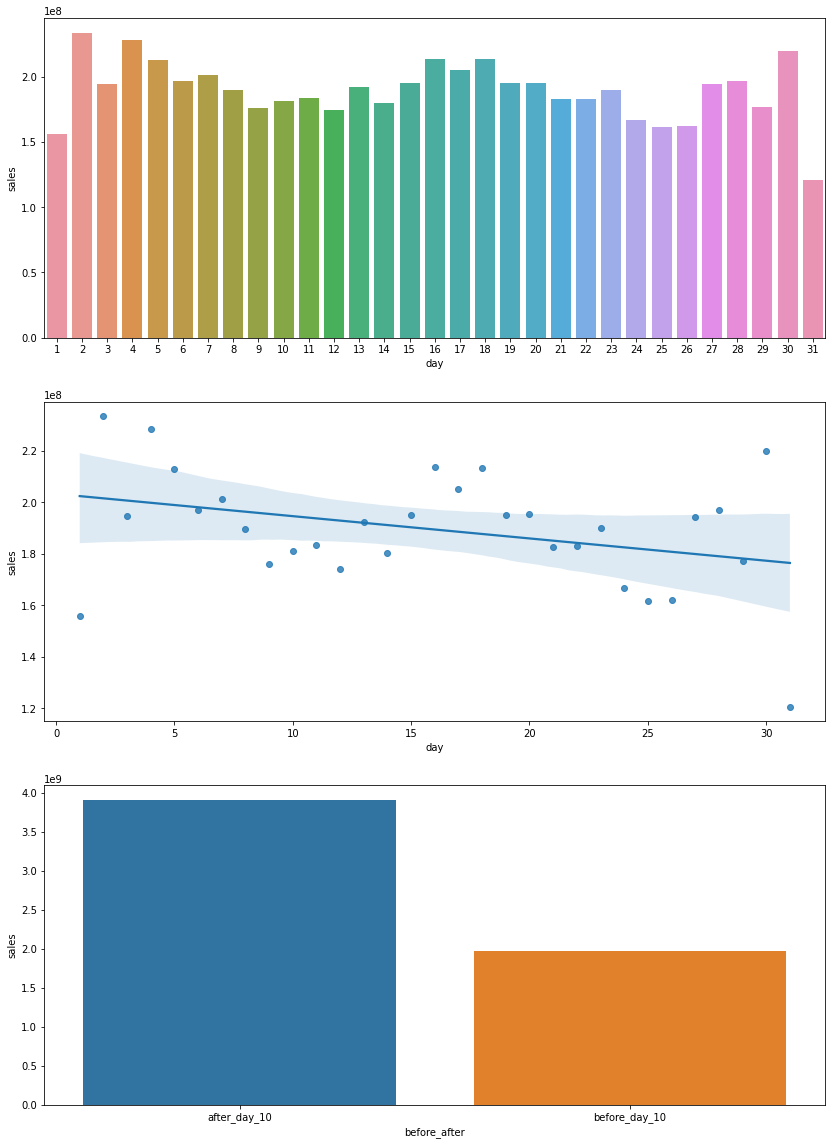

In [39]:
# Dados agrupados por dia
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

# Tamanho da figura
plt.figure(figsize = (14,20));

# Subplots
plt.subplot(3,1,1)
sns.barplot(data = aux1, x = 'day', y = 'sales');

plt.subplot(3,1,2)
sns.regplot(data = aux1, x = 'day', y = 'sales');

plt.subplot(3,1,3)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1.groupby('before_after').sum().reset_index()
sns.barplot(data = aux2, x = 'before_after', y = 'sales');

### H12: Lojas vendem mais durante o segundo semestre do ano?
- **FALSO:** Vemos que há uma tendência de queda da soma de vendas a partir do mês 7 e não de subida como esperávamos. 

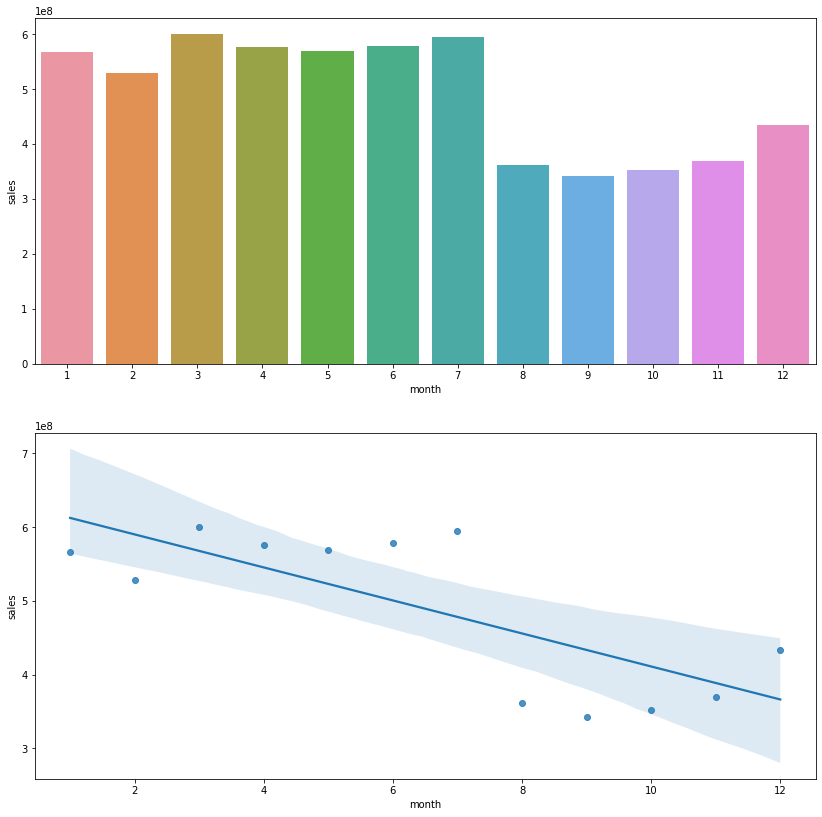

In [40]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize = (14,14));

plt.subplot(2,1,1);
sns.barplot(data = aux1, x = 'month', y = 'sales');

plt.subplot(2,1,2);
sns.regplot(data = aux1, x = 'month', y = 'sales');

### Resumo de Hipóteses: 
Nesse primeiro ciclo de CRISP, classificamos as hipóteses com a seguinte tabela: <br>
**OBSERVAÇÂO:** Estas classificações podem ser alteradas conforme aplicarmos em nosso modelo de Machine Learning.

In [41]:
resumo = {'Hipoteses':    ['H1',     'H2',     'H3',    'H4',   'H5',    'H6',   'H7',    'H8',    'H9',    'H10',   'H11',   'H12'],
         'Classificação': ['Falso', 'Falso', 'Falso', 'Falso', 'Falso', 'Falso','Falso', 'Falso', 'Falso', 'Falso', 'Falso', 'Falso'],
         'Relevância':    ['Baixa', 'Media', 'Media', 'Media', 'Baixa', 'Baixa','Alta',  'Baixo', 'Alta',  'Alta',  'Alta',  'Alta']}
df_res = pd.DataFrame(resumo).set_index('Hipoteses')
df_res

,Classificação,Relevância
Hipoteses,,
H1,Falso,Baixa
H2,Falso,Media
H3,Falso,Media
H4,Falso,Media
H5,Falso,Baixa
H6,Falso,Baixa
H7,Falso,Alta
H8,Falso,Baixo
H9,Falso,Alta


## Análise Multivariada
- Um dos objetivos da análise multivariada é a simplificação do modelo. <br>
Sendo que para realizar essa simplificação, uma das formas que iremos utilizar é a correlação, sendo que variáveis com correlação alta significa que possuem o mesmo tipo de dados, para isso teremos que eliminar uma destas. <br><br>

- Iremos utilizar dois métodos distintos de correlação:
    - Usaremos o método de Pearson para dados numéricos.
    - Usaremos o método cramer v para dados categóricos.

Realizando a tabela de **CORRELAÇÂO** em **VARIÁVEIS NUMÉRICAS**

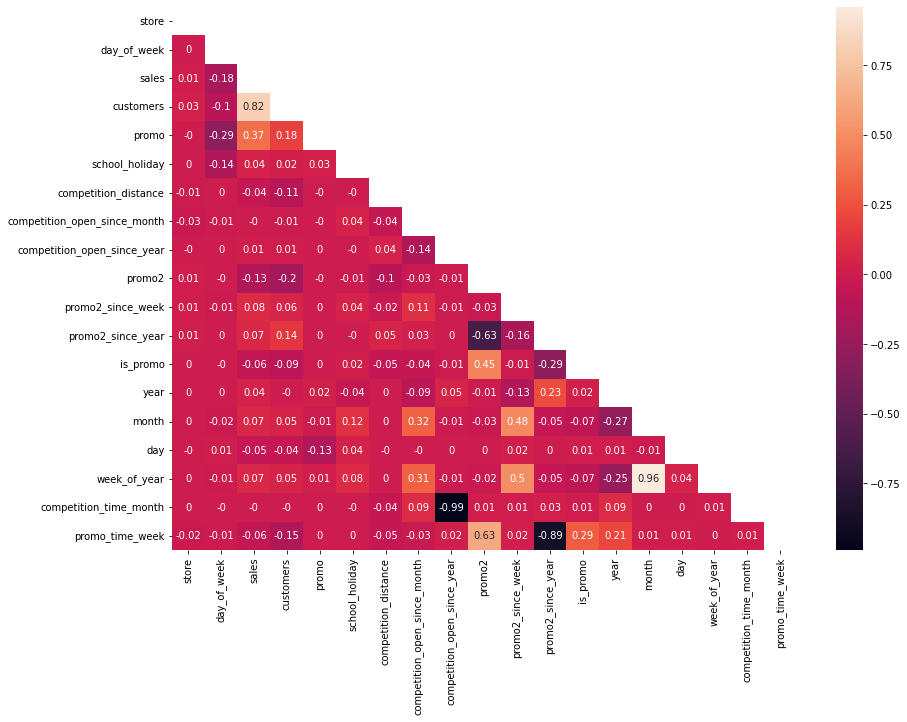

In [42]:
df_num = df4.select_dtypes(include = ['int64', 'float64'])

plt.figure(figsize = (14,10));
corr = df_num.corr().round(2)
mask = np.triu(np.ones_like(corr, dtype=bool));
sns.heatmap(corr, annot = True, mask = mask);

Realizando a tabela de **CORRELAÇÂO** em **VARIÁVEIS CATEGÓRICAS**
- Para essa iremos utilizar a fórmula de cramer localizada na aba "Funções Suporte".

In [43]:
df_cat = df4.select_dtypes(include = 'object').drop('year_week', axis = 1)
df_cat 

,state_holiday,store_type,assortment,month_promo
0,christmas,c,basic,Jul
1,christmas,a,basic,Jul
2,christmas,a,basic,Jul
3,christmas,c,extended,Jul
4,christmas,a,basic,Jul
...,...,...,...,...
1016776,public_holiday,b,basic,Jan
1016827,public_holiday,b,extra,Jan
1016863,public_holiday,b,extra,Jan
1017042,public_holiday,b,extra,Jan


In [44]:
# Criação da tabela de cramer-v retornando um dataframe com os números calculados.
rows = []
for var1 in df_cat:
    cols = []
    for var2 in df_cat:
        cramer = cramer_v(df_cat[var1], df_cat[var2])
        cols.append(round(cramer, 2))
    rows.append(cols)
cramer_results = np.array(rows)
df_cramer = pd.DataFrame(cramer_results, columns = df_cat.columns, index = df_cat.columns)

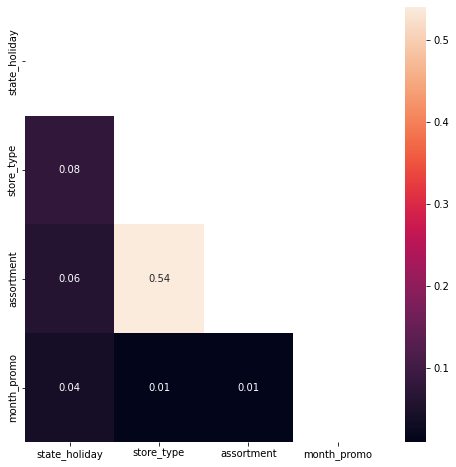

In [45]:
# Criando um heatmap com os valores criados.
plt.figure(figsize = (8,8))
mask = np.triu(np.ones_like(df_cramer, dtype=bool));
sns.heatmap(df_cramer, annot=True, mask = mask);

# PREPARAÇÃO DOS DADOS

In [46]:
df5 = df4.copy()

## Normalização
Nesta seção iremos verificar quais os dados possuem uma distribuição normal.

Como neste caso os dados não possuem uma distribuição normal iremos pular essa etapa.

## Rescalonamento
Nesta seção iremos rescalonar as **VARIÁVEIS NUMÉRICAS** que consideramos **RELEVANTES**, **RESULTANTES** estas do **TESTE DE HIPÓTESES**.<br>

- As variáveis que utilizaremos para o rescalonamento são: 
    - competition_distance
    - competition_time_month
    - promo_time_week
    - year
    - day_of_week
    - day
    - month
    - year_week

- Nesta iremos separar as variáveis cíclicas das não cíclicas, pois as primeiras precisam de um outro tratamento que faremos a seguir:
    - Cíclicas:
        - day_of_week
        - day
        - month
        - year_week
    - Não cíclicas:
        - competition_distance
        - competition_time_month
        - promo_time_week
        - year

 - Transformação de dados não ciclicos: <br>
 Iremos primeiro verificar a existência de outliers, para isso realizamos os seguintes gráficos:

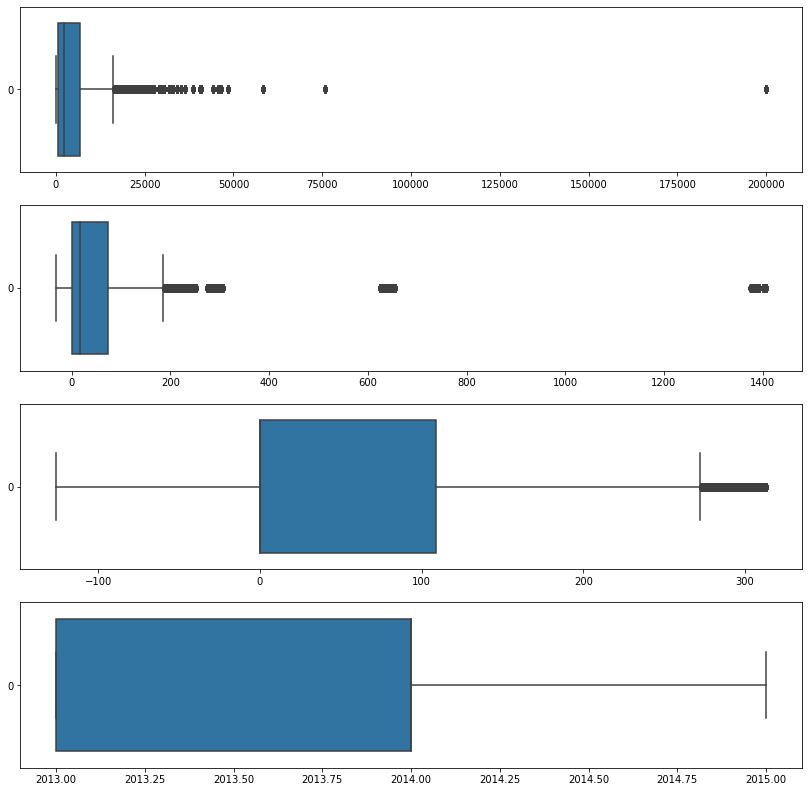

In [47]:
plt.figure(figsize = (14,14));

plt.subplot(4,1,1);
sns.boxplot(data = df5.competition_distance, orient = 'h');

plt.subplot(4,1,2);
sns.boxplot(data = df5.competition_time_month, orient = 'h');

plt.subplot(4,1,3);
sns.boxplot(data = df5.promo_time_week, orient = 'h');

plt.subplot(4,1,4);
sns.boxplot(data = df5.year, orient = 'h');

vemos que na **variável** **competition_distance** e **competition_time_moth** há a presença de **outliers**, enquanto na **promo_time_week** e **year não contém outliers**, para isso temos que realizar dois tratamentos distintos, como no código abaixo: 

In [48]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## Transformação

- Transformação de dados cíclicos:
    - day_of_week
    - day
    - month
    - year_week <br><br>
- Para transformarmos os dados cíclicos em numéricos, iremos aplicar a trigonometria, separando o círculo em segmentos e calculando o seno e cosseno.

In [49]:
# day of week
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * ( 2 * np.pi / 7) ) )
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * ( 2 * np.pi / 7) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: x * np.sin(x * ( 2 * np.pi / 30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: x * np.cos(x * ( 2 * np.pi / 30 ) ) )

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2 * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2 * np.pi/12 ) ) )

# Week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52 ) ) )

### Encoding
Nesta etapa iremos transformar os dados categóricos em numéricos.

In [50]:
# One Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# Ordinal Encoding
assort_map = {'basic':1, 'extended':2, 'extra':3}
promo_map = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

df5['assortment'] = df5['assortment'].map(assort_map)
df5['month_promo'] = df5['month_promo'].map(promo_map)

### Transformação da Variável Reposta

In [51]:
df5['sales'] = np.log1p(df5['sales'])

# SELEÇÃO DE VARIÁVEIS

In [52]:
df6 = df5.copy()

### Separando em Treino e Teste
Iremos inicialmente remover as colunas que contém datas, exceto a 'date' e em seguida iremos separar os dados para treino e teste. <br>
**Treino:** Antes das 6 últimas semanas.<br>
**Teste:** Últimas 6 semanas.

In [53]:
drop_columns = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(drop_columns, axis = 1)

In [54]:
# X treino e teste
X_train = df6[df6['date'] < '2015-06-19']
X_test = df6[df6['date'] >= '2015-06-19']

#y treino e teste
y_train = df6[df6['date'] < '2015-06-19']['sales']
y_test = df6[df6['date'] >= '2015-06-19']['sales']

### Seleção de Variáveis utilizando o BORUTA
**OBSERVAÇÂO:** Como o boruta é um lagoritmo que necessita de um computador potente reutilizamos o resultado de outros usuários que já treinaram este algoritmo.

In [55]:
# Treino e Teste: somente números
#X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
#y_train_n = y_train.values.ravel()

# Random Forest 
#rf = RandomForestRegressor(n_jobs = -1)

# Boruta 
#boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n)

In [56]:
#cols_selected = boruta.support_.tolist()

# Best Features
#X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
#cols_selected_boruta = train_fs.iloc[:, cols_selected].columns.to_list()

# Not Selected
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [57]:
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 
                        'competition_open_since_month', 'competition_open_since_year', 'promo2',
                       'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week']

feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# MODELOS DE MACHINE LEARNING

In [58]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## Modelos Lineares

### Average Method

- Este método utilizaremos como **BASE** para avaliação dos **OUTROS MÉTODOS** de "Machine Learning", sendo que neste método calculamos a média dos dados e então calculamos o erro (MAE, MAPE e RMSE). 

In [59]:
# Definindo o baseline para outros métodos 
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns =  {'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, on = 'store', how = 'left')

yhat_baseline = aux1['predictions']

In [60]:
mn_error = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
mn_error

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800,0.455,3367722.459


### Linear Regression Model

In [61]:
# Fit model
lr = LinearRegression().fit(x_train, y_train)

# Predict
yhat_lr = lr.predict(x_test)

# Compare Error
lr_result = ml_error('Linear Regressor', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regressor,1903.674,0.303,7270582.413


Podemos ver que o RMSE tem um valor maior que o "Average Method", isso representa que este possui um pior resultado comparado a média dos dados, sendo então descartado para aplicação.

### Linear Regression Cross Validation
- Usaremos o cross validation para verificar se houve uma melhora ou não na performance do modelo.

In [62]:
# separate the data 
x_training = X_train[cols_selected_boruta_full]

# Aplicando o cross validation no modelo
lr_cross_val = cross_validation(x_training, 5, 'Cross Validation Regression', lr, verbose=False)
lr_cross_val

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Cross Validation Regression,2103.5+/-318.14,0.3+/-0.01,9233323.3+/-3192952.27


### Linear Regression Regularized Model - Lasso 

In [63]:
# Fit model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

# Predict
yhat_lrr = lrr.predict(x_test)

# Compare Error
lrr_result = ml_error('Lasso Regressor', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso Regressor,1909.483,0.292,7653537.214


Podemos ver que o RMSE tem um valor maior tanto quanto o "Average Method" e o "Linear Regression", isso representa que este possui um pior resultado comparado aos dois modelos anteriores, sendo então descartado para aplicação.<br>
- Com isso vemos que os modelos lineares não apresentam um bom desempenho em nosso modelo, sendo este bem mais complexo, com isso iremos utilizar os modelos não lineares.

### Cross Validation - Lasso

In [64]:
# Separando o modelo de treino
x_training = X_train[cols_selected_boruta_full]

# Aplicando o cross validation no modelo
lrr_cross_val = cross_validation(x_training, 5, 'Cross Validation Lasso', lrr, verbose=False)
lrr_cross_val

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Cross Validation Lasso,2134.61+/-342.3,0.29+/-0.01,9745968.94+/-3351328.34


## Modelos Não Lineares

### Random Forest

In [65]:
# Random Forest
rf = RandomForestRegressor(n_estimators= 100, n_jobs = -1, random_state = 42, warm_start = True ).fit(x_train, y_train)

# Predict 
yhat_rf = rf.predict(x_test)

# Compare Error
rf_result = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf))

In [66]:
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,912.642,0.140,1671677.065


### Cross Validation - Random Forest

In [67]:
# Separando o modelo de treino
x_training = X_train[cols_selected_boruta_full]

# Aplicando o cross validation no modelo
rf_cross_val = cross_validation(x_training, 5, 'Cross Validation Forest', rf, verbose=False)
rf_cross_val

/home/denis/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:420: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.

/home/denis/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:420: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.

/home/denis/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:420: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.

/home/denis/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:420: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.

/home/denis/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:420: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



,Model Name,MAE CV,MAPE CV,RMSE CV
0,Cross Validation Forest,784.76+/-150.27,0.11+/-0.02,1318263.22+/-628313.98


### XGBoost Regressor

In [68]:
# XGB Regressor
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                            n_estimators = 100,
                            eta = 0.01,
                            max_depth = 10,
                            subsample = 0.7,
                            colsample_bytree = 0.9).fit(x_train, y_train)

# Predict
yhat_xgb = model_xgb.predict(x_test)

# Compare Error
xgb_result = ml_error('XGB Regressor', np.expm1(y_test), np.expm1(yhat_xgb))

In [69]:
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGB Regressor,6683.175,0.949,53717493.404


### Cross Validarion - XBoost

In [70]:
# Separando o modelo de treino
x_training = X_train[cols_selected_boruta_full]

# Aplicando o cross validation no modelo
xgb_cross_val = cross_validation(x_training, 5, 'Cross Validation - XGBoost', model_xgb, verbose=True)


kfold Number: 5

kfold Number: 4

kfold Number: 3

kfold Number: 2

kfold Number: 1


In [71]:
xgb_cross_val

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Cross Validation - XGBoost,7050.96+/-593.98,0.95+/-0.0,60022230.63+/-11053772.41


### Compare Model Performance
- Nesta iremos realizar uma compilação dos resultados e verifcar 

In [72]:
df_compare = pd.concat([mn_error, lr_result, lrr_result, rf_result, xgb_result])
df_compare.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest,912.642,0.140,1671677.065
0,Average Model,1354.800,0.455,3367722.459
0,Linear Regressor,1903.674,0.303,7270582.413
0,Lasso Regressor,1909.483,0.292,7653537.214
0,XGB Regressor,6683.175,0.949,53717493.404


In [73]:
df_compare = pd.concat([lr_cross_val, lrr_cross_val, rf_cross_val, xgb_cross_val])
df_compare.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Cross Validation Forest,784.76+/-150.27,0.11+/-0.02,1318263.22+/-628313.98
0,Cross Validation - XGBoost,7050.96+/-593.98,0.95+/-0.0,60022230.63+/-11053772.41
0,Cross Validation Regression,2103.5+/-318.14,0.3+/-0.01,9233323.3+/-3192952.27
0,Cross Validation Lasso,2134.61+/-342.3,0.29+/-0.01,9745968.94+/-3351328.34


Apesar do Random Forest ter um menor erro RMSE, ou seja, uma melhor perfomance, **utilizaremos o algoritmo XGBoost** pois este utiliza menos memória e é mais rápido que o o algoritmo Random Forest.

# HIPERPARAMETER FINE TUNNING

Neste setor iremos selecionar quais os melhores hiperparâmetros do modelo de machinea learning selecionado.<br>
Sendo que existem três formas de realizarmos essa seleção dos hiperparâmetros:<br>
- **Random Search:** Nesta iremos gerar uma lista com valores possíveis e então o algoritmo irá realizar uma seleção randômica desses valores, treinar com o cross validation e nos retornar uma tabela com os erros.
- **Grid Search:** Nesta o algoritmo irá realizar um cross validation em cada hiperparâmetro e gerar uma tabela de erros.
- **Bayesian Search:** Nesta os algoritmos definem os hiperparâmetros seguindo a teoria de bayes e este irá aprender quais tem um melhor desempenho.

Neste primeiro ciclo escolhemos o algoritmo Random Search pois este tem uma maior velocidade comparado com os outros dois, sendo possível realizar o ciclo com mais velocidade, apesar de perdemos em acurácia. 

### Random Search

In [74]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 5

In [75]:
#final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items() }
#    print(hp)
    
#    model_xgb = xgb.XGBRegressor(objective = 'ger:squarederror',
#                                n_estimators = hp['n_estimators'], 
#                                eta = hp['eta'], 
#                                max_depth = hp['max_depth'],
#                                subsample = hp['subsample'], 
#                                colsample_bytree = hp['colsample_bytree'], 
#                                min_child_weight = hp['min_child_weight'])
    
#    result = cross_validation(x_training, 5, 'XGBoost', model_xgb, verbose = True)
    
#    final_result = pd.concat([final_result, result])
    
#final_result

Sendo que após treinarmos esse algoritmo chegamos com os seguites valores para aplicarmos nos hiperparâmentros:

In [110]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
}

model_xgb_tuned = model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                               n_estimators = param_tuned['n_estimators'], 
                                               eta = param_tuned['eta'], 
                                               max_depth = param_tuned['max_depth'],
                                               subsample = param_tuned['subsample'], 
                                               colsample_bytree = param_tuned['colsample_bytree'], 
                                               min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

# Predict
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)
     
# 
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,965.148,0.149,1865858.652


# INTERPRETAÇÃO DO ERRO

Nesta etapa iremos demonstrar o quanto de lucro será gerado no modelo caso seguirmos o modelo selecionado, para isso utilizaremos erro MAE e o MAPE como parâmetro, sendo estes a média da diferença entre o valor real e o previsto.

In [111]:
df9 = X_test[cols_selected_boruta_full]

In [112]:
# Criação das variáveis e realizando a transformação reversa
df9['sales'] = np.expm1(df9['sales'])
df9['predict'] = np.expm1(yhat_xgb_tuned)

/tmp/ipykernel_20866/3913989660.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_20866/3913989660.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Performance do Negócio
- Nesta etapa iremos verificar a quantidade de dinheiro que o nosso modelo gerou nas próximas 6 semanas conforme o nosso problema principal de negócio.

In [113]:
df_aux = df9[['store', 'sales', 'predict']].groupby('store').sum().reset_index()

df_aux_1 = df9[['store', 'sales', 'predict']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predict'])).reset_index().rename(columns = {0:'MAE'})
df_aux_2 = df9[['store', 'sales', 'predict']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predict'])).reset_index().rename(columns = {0:'MAPE'})

df_aux12 = pd.merge(df_aux_1, df_aux_2, how = 'inner', on = 'store')
df9_aux = pd.merge(df_aux12, df_aux, how = 'inner', on = 'store')

df9_aux['best_scenario'] = df9_aux['predict'] + df9_aux['MAE']
df9_aux['worst_scenario'] = df9_aux['predict'] - df9_aux['MAE']

df9_aux = df9_aux[['store', 'predict', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [115]:
df9_aux

,store,predict,worst_scenario,best_scenario,MAE,MAPE
0,1,166528.953,166162.512,166895.395,366.441,0.088
1,2,186303.656,185609.777,186997.535,693.879,0.154
2,3,275181.562,274092.804,276270.321,1088.759,0.166
3,4,346040.094,345012.734,347067.454,1027.360,0.099
4,5,168589.703,167816.859,169362.547,772.844,0.217
...,...,...,...,...,...,...
1110,1111,181053.516,180038.515,182068.516,1015.001,0.230
1111,1112,342307.438,341016.740,343598.135,1290.698,0.149
1112,1113,249509.562,248887.629,250131.496,621.933,0.099
1113,1114,801470.875,799380.666,803561.084,2090.209,0.090


Com essa tabela, podemos visualizar qual a porcentagem de erro (MAPE) gerada por cada loja, sendo que quanto maior o mape, maior a incerteza de vendas da loja.<br>
Outra forma de verificarmos a porcentagem de MAE de cada loja, podemos plotar um gráfico de pontos abaixo:

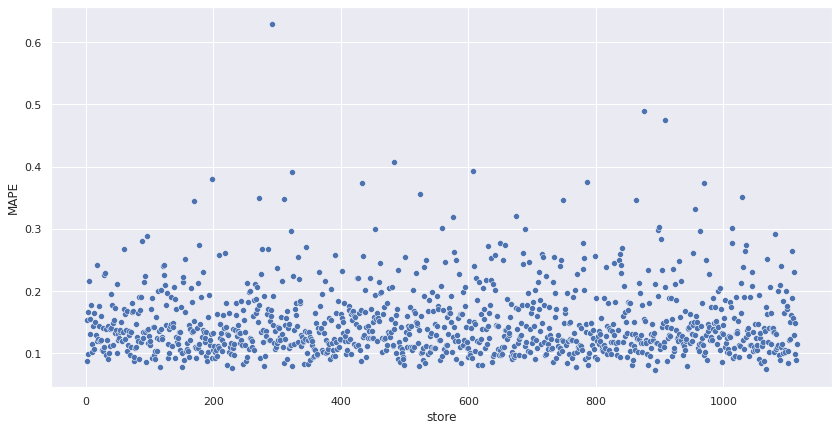

In [116]:
plt.figure(figsize = (14,7));
sns.set_theme()
sns.scatterplot(data = df9_aux, x = 'store', y = 'MAPE');

Verificamos que a maioria dos preços previstos das lojas estão na faixa de erro entre 10 e 20%, sendo isto algo a ser melhorano no pŕoximo ciclo do CRISP caso a equipe de negócio assim desejar.

### Performance Total
Nesse iremos gerar um resumo com a soma total dos valores, com o pior e melhor cenário.

In [117]:
df_scenarios_sum = df9_aux[['best_scenario', 'worst_scenario', 'predict']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'scenarios', 0: 'values'})
df_scenarios_sum['values'] = df_scenarios_sum['values'].map('R$ {:,.2f}'.format) 
df_scenarios_sum

,scenarios,values
0,best_scenario,"R$ 288,554,280.06"
1,worst_scenario,"R$ 286,397,838.89"
2,predict,"R$ 287,476,064.00"


Com isso vemos que há uma diferença de aproximadamente 2 milhoes, entre o melhor e o pior cenário. <br>
Lembrando que isso deve ser discutido com a equipe de negócio se o resultado está ou não satisfatório para assim realizarmos ou não o segundo ciclo do CRISP.

### Machine Learning Performance

In [118]:
df9['error'] = df9['sales'] - df9['predict']
df9['error_rate'] = df9['sales'] / df9['predict']

/tmp/ipykernel_20866/3436199054.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_20866/3436199054.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='predict', ylabel='error'>

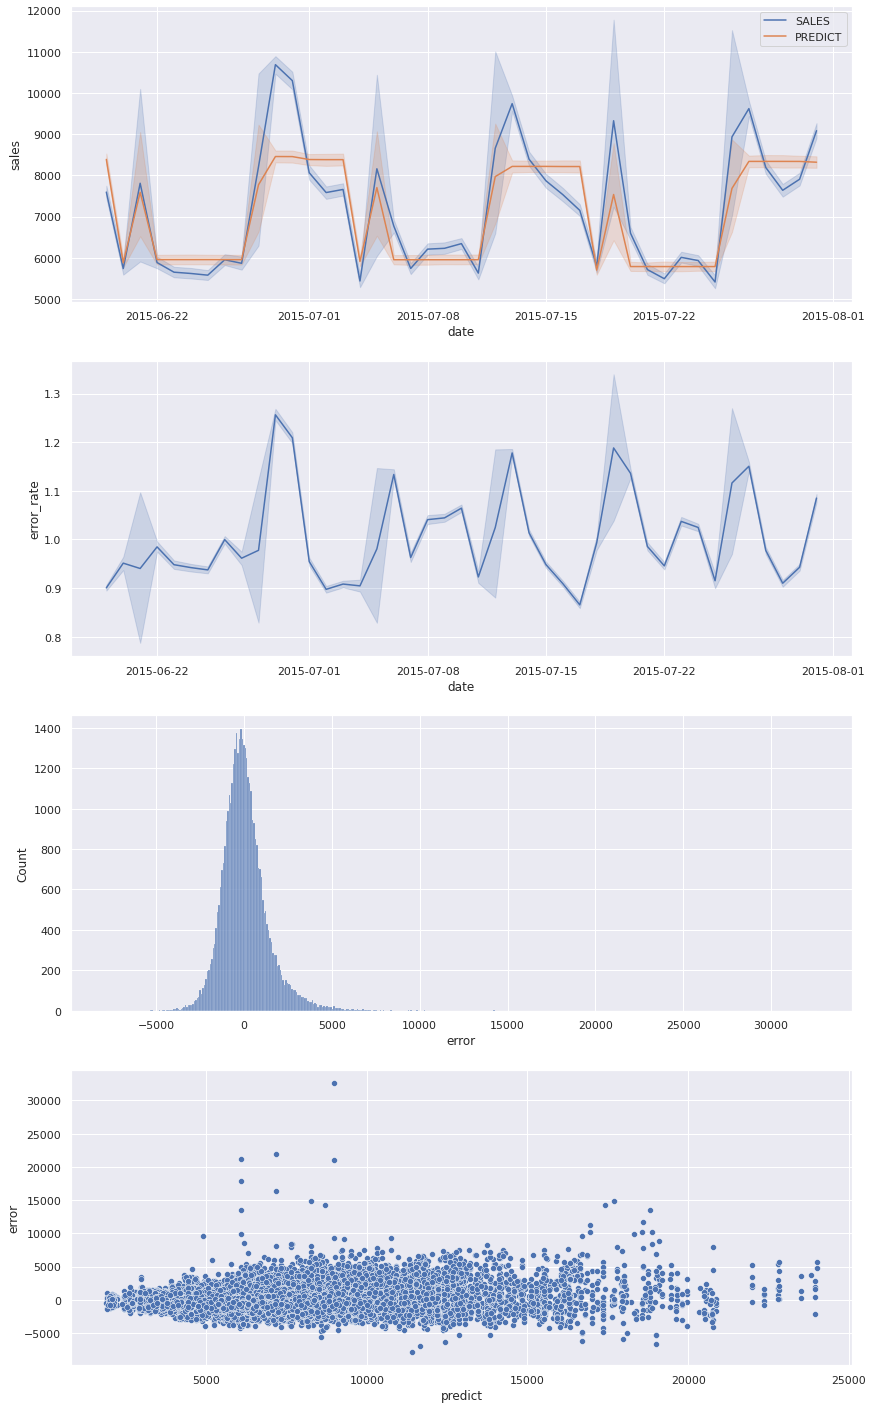

In [120]:
fig, axis = plt.subplots(4,1, figsize = (14,25))

sns.lineplot(data = df9, x = 'date', y = 'sales', label = 'SALES', ax = axis[0])
sns.lineplot(data = df9, x = 'date', y = 'predict', label = 'PREDICT', ax = axis[0])

sns.lineplot(data = df9, x = 'date', y = 'error_rate', ax = axis[1])

sns.histplot(data = df9['error'], ax = axis[2]);

sns.scatterplot(x = df9['predict'], y = df9['error'], ax = axis[3])

Com esses gráficos tiramos as seguintes conclusões:

- No primeiro gráfico verificamos a previsão de vendas comparado com os dados reais de vendas, e vimos que ainda há uma discrepância entre os valores previstos com os reais, nos próximos ciclos teremos que ajustar nossos parâmetros ou hiperparâmetros para melhor desempenho do nosso modelo.

- No segundo gráfico vemos em quais dias o modelo fez uma subestimação (menos que 1) ou uma superestimação (maior que 1) 

- No terceiro demonstra a distribuição do erro do nosso modelo.

- No último gráfico verificamos a análise de resíduo, sendo que quanto mais o formato cilíndrico o gráfico apresenta, menos resíduo este possui.